<font size=10em>Multi-label language classification</font>  
<font size=6em>BERT - TensorFlow 2 & Hugging Face Transformers Library</font>

In [ ]:
__author__ = 'takumig'

<font size=4em>abstract</font>  
In this notebook we will learn how to solve the [Jigsaw Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge).  
The challenge is to determine if a comment taken from a Wikipedia edit discussion can be classified as one or more of the following:  
- toxic
- severe_toxic
- obscene
- threat
- insult
- identity_hate

# preparation

## Settings

In [ ]:
# setting up kaggle authentication
# Just do one of the following

# -------------------------------------------------------------
# # 1. change permission
# ! chmod 600 ~/.kaggle/kaggle.json

# -------------------------------------------------------------
# 2. set environment variable    <<======== !!choose now!!
import os
import json

with open("~/.kaggle/kaggle.json", mode="r") as f:
    json_data = json.load(f)
os.environ["KAGGLE_USERNAME"] = json_data["username"]
os.environ["KAGGLE_KEY"] = json_data["key"]

useing environments
- [Kaggle API](https://github.com/Kaggle/kaggle-api)
- [Docker container registory](https://console.cloud.google.com/gcr/images/kaggle-gpu-images/GLOBAL/python@sha256:7b500f6081e92f812db283da919abe5e305c17a7130d456ddd8ddbd7da786e50/details)
- [GitHub](https://github.com/Kaggle/docker-python/blob/main/Dockerfile.tmpl)  

## Data Preparation

In [ ]:
# # download data using kaggle API
# ! kaggle competitions download -c jigsaw-toxic-comment-classification-challenge
# # unzip the downloaded data
# ! unzip jigsaw-toxic-comment-classification-challenge.zip

In [ ]:
# If the error occurs in the version, please activate below
!pip install transformers==2.3.0

In [ ]:
# ds library
import numpy as np
import pandas as pd
import tensorflow as tf

# drawing　library
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# others 
from tqdm.notebook import tqdm

In [ ]:
df_train = pd.read_csv('train.csv.zip')
df_test = pd.read_csv('test.csv.zip')

# EDA

## overhead view

In [ ]:
df_train

In [ ]:
df_test

In [ ]:
df_train.info()

## lavel columns

In [ ]:
df_train.describe()

In [ ]:
comments = df_train.drop(['id','comment_text'],axis = 1)
for i in comments.columns :
    print(f"percent of {i}: {round(100*comments[i].mean(),2)}%")

## comment_colmun

In [ ]:
lens = df_train.comment_text.str.len()

print(f"""\
mean: {lens.mean():.2f}\n \
std: {lens.std():.2f}\n \
min: {lens.min()}\n \
max: {lens.max()}\n \
""")

In [ ]:
fig, ax = plt.subplots(figsize=(25, 7))
sns.histplot(data=lens, ax=ax, kde=True)

In [ ]:
label_cols = [cname for cname in df_train.columns 
              if df_train[cname].dtype == "int64"]
label_cols

# building the model

## data pipeline
- Preprocessing (Tokenization, Truncation & Padding)
- Creating efficient data pipelines using [tf.data](https://www.tensorflow.org/guide/data).  
- Base model is [bert-base-uncased](https://huggingface.co/bert-base-uncased)
- [Hugging Face Glossaary](https://huggingface.co/docs/transformers/glossary)

In [ ]:
df_test_labels = pd.read_csv("test_labels.csv.zip", index_col='id')

In [ ]:
from transformers import BertTokenizer
from keras.preprocessing.sequence import pad_sequences

bert_model_name = 'bert-base-uncased'

tokenizer = BertTokenizer.from_pretrained(bert_model_name, do_lower_case=True)
MAX_LEN = 128

def tokenize_sentences(sentences, tokenizer, max_seq_len = 128):
    tokenized_sentences = []

    for sentence in tqdm(sentences):
        tokenized_sentence = tokenizer.encode(
                            sentence,                  # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = max_seq_len,  # Truncate all sentences.
                    )
        
        tokenized_sentences.append(tokenized_sentence)

    return tokenized_sentences

def create_attention_masks(tokenized_and_padded_sentences):
    attention_masks = []

    for sentence in tokenized_and_padded_sentences:
        att_mask = [int(token_id > 0) for token_id in sentence]
        attention_masks.append(att_mask)

    return np.asarray(attention_masks)

input_ids = tokenize_sentences(df_train['comment_text'], tokenizer, MAX_LEN) # Stores encoded body data
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
attention_masks = create_attention_masks(input_ids)

- Split train test

In [ ]:
from sklearn.model_selection import train_test_split

labels =  df_train[label_cols].values

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=0, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, random_state=0, test_size=0.1)

train_size = len(train_inputs)
validation_size = len(validation_inputs)

- Creating dataset using [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)

In [ ]:
BATCH_SIZE = 32
NR_EPOCHS = 1

def create_dataset(data_tuple, epochs=1, batch_size=32, buffer_size=10000, train=True):
    dataset = tf.data.Dataset.from_tensor_slices(data_tuple)
    if train:
        dataset = dataset.shuffle(buffer_size=buffer_size)
    dataset = dataset.repeat(epochs)
    dataset = dataset.batch(batch_size)
    if train:
        dataset = dataset.prefetch(1)
    
    return dataset

train_dataset = create_dataset((train_inputs, train_masks, train_labels), epochs=NR_EPOCHS, batch_size=BATCH_SIZE)
validation_dataset = create_dataset((validation_inputs, validation_masks, validation_labels), epochs=NR_EPOCHS, batch_size=BATCH_SIZE)

## BERT model
- Load the pretrained [BERT](https://arxiv.org/pdf/1810.04805.pdf) base-model from Transformers library.
- Take the first hidden-state from BERT output and feed it into a Dense layer with 6 neurons and sigmoid activation. 
- The outputs of this layer can be interpreted as probabilities for each of the 6 classes.
- Better performance with [tf.function](https://www.tensorflow.org/guide/function?hl=en)

In [ ]:
from transformers import TFBertModel
from tensorflow.keras.layers import Dense, Flatten

class BertClassifier(tf.keras.Model):    
    def __init__(self, bert: TFBertModel, num_classes: int):
        super().__init__()
        self.bert = bert
        self.classifier = Dense(num_classes, activation='sigmoid')
        
    @tf.function
    def call(self, input_ids, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None):
        outputs = self.bert(input_ids,
                               attention_mask=attention_mask,
                               token_type_ids=token_type_ids,
                               position_ids=position_ids,
                               head_mask=head_mask)
        cls_output = outputs[1]
        cls_output = self.classifier(cls_output)
                
        return cls_output

model = BertClassifier(TFBertModel.from_pretrained(bert_model_name), len(label_cols))

## Training Loop
- Use [BinaryCrossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy) as loss function
- Use the [AdamW optimizer](https://www.tensorflow.org/addons/api_docs/python/tfa/optimizers/AdamW) with 1-cycle-policy from the Transformers library
- [Metrics](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Mean)
- Better performance with [tf.function](https://www.tensorflow.org/guide/function?hl=en)
- AUC evaluation metrics

In [ ]:
import time
from transformers import create_optimizer

steps_per_epoch = train_size // BATCH_SIZE
validation_steps = validation_size // BATCH_SIZE

# Loss Function
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=False)
train_loss = tf.keras.metrics.Mean(name='train_loss')
validation_loss = tf.keras.metrics.Mean(name='test_loss')

# Optimizer (with 1-cycle-policy)
warmup_steps = steps_per_epoch // 3
total_steps = steps_per_epoch * NR_EPOCHS - warmup_steps
optimizer = create_optimizer(init_lr=2e-5, num_train_steps=total_steps, num_warmup_steps=warmup_steps)

# Metrics
train_auc_metrics = [tf.keras.metrics.AUC() for i in range(len(label_cols))]
validation_auc_metrics = [tf.keras.metrics.AUC() for i in range(len(label_cols))]

@tf.function
def train_step(model, token_ids, masks, labels):
    labels = tf.dtypes.cast(labels, tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(token_ids, attention_mask=masks)
        loss = loss_object(labels, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables), 1.0)

    train_loss(loss)

    for i, auc in enumerate(train_auc_metrics):
        auc.update_state(labels[:,i], predictions[:,i])
        
@tf.function
def validation_step(model, token_ids, masks, labels):
    labels = tf.dtypes.cast(labels, tf.float32)

    predictions = model(token_ids, attention_mask=masks, training=False)
    v_loss = loss_object(labels, predictions)

    validation_loss(v_loss)
    for i, auc in enumerate(validation_auc_metrics):
        auc.update_state(labels[:,i], predictions[:,i])
                                              
def train(model, train_dataset, val_dataset, train_steps_per_epoch, val_steps_per_epoch, epochs):
    for epoch in range(epochs):
        print('=' * 50, f"EPOCH {epoch}", '=' * 50)

        start = time.time()

        for i, (token_ids, masks, labels) in enumerate(tqdm(train_dataset, total=train_steps_per_epoch)):
            train_step(model, token_ids, masks, labels)
            if i % 1000 == 0:
                print(f'\nTrain Step: {i}, Loss: {train_loss.result()}')
                for i, label_name in enumerate(label_cols):
                    print(f"{label_name} roc_auc {train_auc_metrics[i].result()}")
                    train_auc_metrics[i].reset_states()
        
        for i, (token_ids, masks, labels) in enumerate(tqdm(val_dataset, total=val_steps_per_epoch)):
            validation_step(model, token_ids, masks, labels)

        print(f'\nEpoch {epoch+1}, Validation Loss: {validation_loss.result()}, Time: {time.time()-start}\n')

        for i, label_name in enumerate(label_cols):
            print(f"{label_name} roc_auc {validation_auc_metrics[i].result()}")
            validation_auc_metrics[i].reset_states()

        print('\n')

        
train(model, train_dataset, validation_dataset, train_steps_per_epoch=steps_per_epoch, val_steps_per_epoch=validation_steps, epochs=NR_EPOCHS)

# predict & submission

In [ ]:
test_input_ids = tokenize_sentences(df_test['comment_text'], tokenizer, MAX_LEN)
test_input_ids = pad_sequences(test_input_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
test_attention_masks = create_attention_masks(test_input_ids)

In [ ]:
TEST_BATCH_SIZE = 32
test_steps = len(df_test) // TEST_BATCH_SIZE

test_dataset = create_dataset((test_input_ids, test_attention_masks), batch_size=TEST_BATCH_SIZE, train=False, epochs=1)

df_submission = pd.read_csv("sample_submission.csv.zip", index_col='id')

for i, (token_ids, masks) in enumerate(tqdm(test_dataset, total=test_steps)):
    sample_ids = df_test.iloc[i*TEST_BATCH_SIZE:(i+1)*TEST_BATCH_SIZE]['id']
    predictions = model(token_ids, attention_mask=masks).numpy()

    df_submission.loc[sample_ids, label_cols] = predictions

In [ ]:
df_submission.to_csv('submission.csv')

-  Send a DM to slack when the process is finished.

In [ ]:
# pip install slack_sdk
import json
from slack_sdk import WebClient

with open("slack.json", mode="r") as f:
    json_data = json.load(f)

token = json_data["token"]

client = WebClient(token)
user_id = json_data["user_id"]

res = client.conversations_open(users=user_id)
dm_id = res['channel']['id']

text = "The BERT study and the creation of the CSV file have been completed."
client.chat_postMessage(channel=dm_id, text=text)

In [ ]:
# submit using kaggle api
! kaggle competitions submit -c jigsaw-toxic-comment-classification-challenge -f submission.csv -m "Predicted using BERT"

# result

Private Score: 0.98403  
Public Score: 0.98374

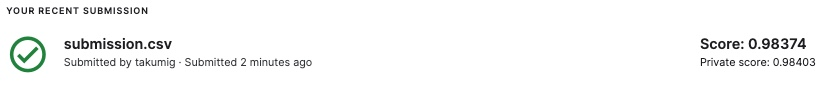

# conclusion

## FYI: Do not use NN

The following results are obtained using NBSVM.  
Features are extracted using Bayes' theorem and then classified by SVM.  
Use logistic regression instead of SVM.  
[Baselines and Bigrams: Simple, Good Sentiment and Topic Classification](https://nlp.stanford.edu/pubs/sidaw12_simple_sentiment.pdf)  
code is here -> [NBSVM.ipynb](http://localhost:8888/lab/tree/work/Kaggle/PJ/jigsaw/NBSVM.ipynb)

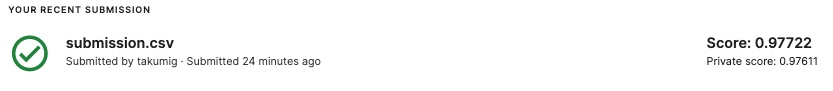

## impressions

Accuracy was greatly improved when BERT was used.  
However, significant costs were incurred.  

 For example, the GPU environment required a GCP environment.  
 Because of time constraints, a high-spec instance was used for this project.  
 The cost was approximately ￥10,000 yen.  
  
In addition, since many methods are provided, implementation was not difficult,  
but I also realized the disadvantage that it is difficult to follow the inner processes.  

If only accuracy is required, such as in kaggle and applications  
I think deep learning is a good way to go.  
I have the impression that it is not suitable for strategic planning in my business.